#  Travelling Salesman Problem

There are several DEAP implementations of the Travelling Salesman Problem (TSP) on the Internet.

1.  [Learning DEAP from examples](https://www.amazon.com/Learning-DEAP-examples-Evolutionary-evolutionary-ebook/dp/B06XHXD2SF) by Ronn Kling.  We are using his code as the basis for this example.

2. See also the TSP implementation by Song Chisung as implemented [here](https://github.com/daydrill/ga_pycon_2016_apac/blob/master/Decision_Making_with_GA_using_DEAP.ipynb), also [here](https://github.com/NelisW/NeuralNetworks-DeepLearning-Notes/blob/master/GAGP/DEAP/code/01-Decision_Making_with_GA_using_DEAP.ipynb).  Song uses  the `folium` package to plot the path on a real map.

3. A very brief post by [Pepper Johnson](https://medium.com/@pasdan/genetic-algorithm-the-travelling-salesman-problem-via-python-deap-f238e0dd1a73), with full code [here](https://github.com/pepper-johnson/sack_lunch/blob/master/Notebooks/GA/Travelling%20Salesman%20Problem%20via%20DEAP.ipynb).

4. The **excellent** [notebook](https://github.com/lmarti/evolutionary-computation-course/blob/master/AEC.03%20-%20Solving%20the%20TSP%20with%20GAs.ipynb) by Luis Marti.  Take the trouble to work through this notebook; the problem description and solution are well documented.

The  implementations differ in some smaller details: Kling uses `array.array` to store the individual details, whereas Marti, Song and Pepper use a `list`.  The other details are very much the same, because the DEAP built-in functions are used.  Johnson has a more elaborate coding style, which appears overly lengthy, but I think this approach will pay of for complex projects.

DEAP implements a large number of 'standard' functions in a framework that makes derivation from, and extension of, these functions relatively easy.  Using the framework is somewhat counter-intuitive, but once you get used to the concepts, the power of this approach really shines.

In [3]:
import matplotlib.pyplot as plt
import sys
import array
import random
import numpy as np

from deap import  algorithms
from deap import  base
from deap import  creator
from deap import  tools

%matplotlib inline


## Set up for this run

In [4]:
doVerbose = True

numCities = 10
POP_SIZE = 100
MAX_GEN = 100
MUT_PROB = 0.2
CX_PROB = 0.8

## Creator 

https://deap.readthedocs.io/en/master/tutorials/basic/part1.html#creating-types  
https://deap.readthedocs.io/en/master/tutorials/basic/part1.html#individual  
https://deap.readthedocs.io/en/master/api/creator.html  

The `creator` class factory provides the facility to use the DEAP classes as base classes but then to derive new classes for new problems.

New classes can be built from any imaginable type, from list to set, dict, PrimitiveTree and more

    deap.creator.create(name, base[, attribute[, ...]])
    
The create() function takes at least two arguments, a name for the newly created class and an existing  base class. Any subsequent argument becomes an attribute of the class.

The new class can have attributes defined by the subsequent keyword arguments passed to the function `create`. If the argument is a class (a name without the parenthesis), the `__init__` function of the supplied class type is called in the initialization of an instance of the newly created  object. It seems that any required parameters in the existing class' `__init__` is taken from the rest of the `create()` parameter list.  
The newly created class (using the name supplied) is then added as an attribute of the `creator` class. Otherwise, if the argument is not a class, (for example an int), it is added as a `static` attribute of the `creator` class.



https://deap.readthedocs.io/en/master/tutorials/basic/part1.html#creating-types

The provided `Fitness` class is an abstract class that needs a weights attribute in order to be functional. A minimizing fitness is built using negatives weights, while a maximizing fitness has positive weights. For example, the following line creates, in the `creator`, a ready to use single objective minimizing fitness named `FitnessMin`:

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    
A multi-objective fitness function with have more elements in the weights tuple.  The tuple `weights=(-1.0,1.0)` means that the first objective is minimised and the the second objective is maximised. The weights can also be used to vary the importance of each objective one against another. This means that the weights can be any real number and only the sign is used to determine if a maximization or minimization is done.

The `creator.create` below creates a new `creator` method that will create an instance of the `FitnessMin` class when invoked.

In [5]:
creator.create("FitnessMin", base.Fitness,weights=(-1.0,))


https://deap.readthedocs.io/en/master/tutorials/basic/part1.html#individual  
https://docs.python.org/3/library/array.html      

    class array.array(typecode[, initializer])

Instantiates an efficient array of type defined in typecode.

The `create.Individual` method can create arbitrary data types: lists, dicts, etc. Variations of this type are possible by inheriting from `array.array` or `numpy.ndarray` as following.

    creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMax)
    creator.create("Individual", numpy.ndarray, fitness=creator.FitnessMax)

Type inheriting from arrays needs a typecode on initialization, just as the original class.

Finally, the `create.Individual` method  must be given a fitness class, created by invoking the creator method that was defined above.


In [6]:
creator.create("Individual",array.array,typecode='i', fitness=creator.FitnessMin)

Song takes the following approach, using a `list` for the individual:

    creator.create("FitnessMulti", base.Fitness, weights=(-1.0,1.0))
    creator.create("Individual", list, fitness=creator.FitnessMulti)
    toolbox = base.Toolbox()

    # Attribute generator 
    toolbox.register("index", np.random.choice, len(df_spot), numSpots, replace=False) # choose numSpots spots

    # Structure initializers
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.index)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Creating toolbox attributes

https://deap.readthedocs.io/en/master/tutorials/basic/part2.html#operators-and-algorithms  

The toolbox is intended to contain all the evolutionary tools, from the object initializers to the evaluation operator. It allows easy configuration of each algorithm. The toolbox has basically two methods, register() and unregister(), that are used to add or remove tools from the toolbox.

In the TSP problem, each city is represented by an index (a number) in the range `range(0,numCities)`.  The index values are sufficient for this purpose, we do not have to use city names.

Create the attribute `indices` to represent the indexes or indices of the cities.

The `random.sample(population, k)` function returns a `k` length list of unique elements chosen from the `population` sequence or set, used for random sampling without replacement (meaning that items are only used once).

https://pynative.com/python-random-sample/

So, in the code below

1. Register an attribute list with numCities, selected randomly from `range(numCities)`

        tooolbox.register('indices',random.sample,range(numCities),numCities)

2. Register the `individual` toolbox method that will create the individuals (the lists of cities), from the attribute defined just above, in the line

        toolbox.register('individual',tools.initIterate, creator.Individual, toolbox.indices)
        
    The parameter `tools.initIterate` is a built-in DEAP function taking two arguments: the function to be called (`creator.Individual`) and the the argument to be supplied (`toolbox.indices`).  

3. Finally, create the population of individuals each comprising a list of `toolbox.individual` instances, which in turn are lists of city indices.

        toolbox.register('population',tools.initRepeat,list,toolbox.individual)

In [7]:
toolbox = base.Toolbox()
toolbox.register('indices',random.sample,range(numCities),numCities)
toolbox.register('individual',tools.initIterate,creator.Individual, toolbox.indices)
toolbox.register('population',tools.initRepeat,list,toolbox.individual)

In [8]:
if doVerbose:
    ind = toolbox.individual()
    print('Demonstrate the indices, individual and population:')
    print(f'indices (city names): {toolbox.indices()}') 
    print(f'Individual (create sequence of cities): {creator.Individual()}')  
    print(f'individual (one sequence of cities): {toolbox.individual()}')  
    print(f'population (population of sequences of cities): {toolbox.population(n=4)}')  


Demonstrate the indices, individual and population:
indices (city names): [3, 8, 5, 2, 9, 0, 1, 7, 4, 6]
Individual (create sequence of cities): Individual('i')
individual (one sequence of cities): Individual('i', [3, 0, 4, 5, 6, 9, 7, 1, 2, 8])
population (population of sequences of cities): [Individual('i', [2, 5, 7, 3, 6, 4, 1, 9, 8, 0]), Individual('i', [9, 7, 3, 1, 8, 5, 0, 4, 2, 6]), Individual('i', [6, 5, 1, 0, 7, 4, 3, 9, 2, 8]), Individual('i', [1, 0, 3, 4, 7, 5, 8, 2, 6, 9])]


## Crossover / Mating

https://deap.readthedocs.io/en/master/tutorials/basic/part2.html#using-the-toolbox  
https://deap.readthedocs.io/en/master/tutorials/basic/part2.html#crossover  

 There is a variety of crossover operators in the deap.tools module. Each crossover has its own characteristics and may be applied to different types of individuals. Be careful to read the documentation of the selected operator in order to avoid undesirable behaviour.

The general rule for crossover operators is that they only mate individuals, this means that an independent copies must be made prior to mating the individuals if the original individuals have to be kept or are references to other individuals (see the selection operator).

In the travelling salesman problem, each city must be visited and no city must be visited twice. The travel sequence is the `individual` defined above. 
The crossover method must therefore mate the `individuals` in the `population` to comply with the above requirement. DEAP has three different crossover methods that will comply and work with indices:

1. [deap.tools.cxOrdered(ind1, ind2)](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxOrdered)

    Executes an ordered crossover (OX) on the input individuals. The two individuals are modified in place. This crossover *only works with index individual sequences*.  A portion of one parent is mapped to a portion of the other parent. Outside the filled portion, the rest is filled up by the remaining genes, where already present genes are omitted and the order is preserved. See 
    [here](http://www.dmi.unict.it/mpavone/nc-cs/materiale/moscato89.pdf) and [here](https://stackoverflow.com/questions/11782881/how-to-implement-ordered-crossover).
    
2. [ deap.tools.cxUniformPartialyMatched(ind1, ind2, indpb)](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxUniformPartialyMatched)
Executes a uniform partially matched crossover (UPMX) on the input individuals. The two individuals are modified in place. This crossover *only works with index individual sequences*.  In this method, two crossover points are selected at random and PMX proceeds by position-wise exchanges. The two crossover points give matching selection.  It affects crossover by position-by-position exchange operations.

3. [ deap.tools.cxPartialyMatched(ind1, ind2)](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxPartialyMatched) 
Executes a partially matched crossover (PMX) on the input individuals. The two individuals are modified in place. This crossover *only works with index individual sequences*. In this method, two crossover points are selected within a certain range of the parents and PMX proceeds by position-wise exchanges. The two crossover points give matching selection.  It affects crossover by position-by-position exchange operations.


In [9]:
toolbox.register('mate',tools.cxOrdered)


## Mutation

https://deap.readthedocs.io/en/master/tutorials/basic/part2.html#mutation  

There is a variety of mutation operators in the deap.tools module. Each mutation has its own characteristics and may be applied to different types of individuals. Be careful to read the documentation of the selected operator in order to avoid undesirable behaviour.

The general rule for mutation operators is that they only mutate, this means that an independent copy must be made prior to mutating the individual if the original individual has to be kept or is a reference to another individual (see the selection operator).

1. [deap.tools.mutShuffleIndexes(individual, indpb)](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutShuffleIndexes)

    Shuffle the attributes of the input individual and return the mutant. The individual is expected to be a sequence. The `indpb` argument is the probability of each attribute to be moved. Usually this mutation is applied on vector of indices. 
    
The following code mutates with a probability of 0.05 and alias the method `tools.mutShuffleIndexes` to ``mutuate`.
 
 
 

In [10]:
toolbox.register('mutate',tools.mutShuffleIndexes, indpb=0.05)

## Select

https://deap.readthedocs.io/en/master/tutorials/basic/part2.html#selection

Selection is made among a population by the selection operators that are available in the deap.tools module. The selection operator usually takes as first argument an iterable container of individuals and the number of individuals to select. It returns a list containing the references to the selected individuals.

It is very important here to note that the selection operators does not duplicate any individual during the selection process. If an individual is selected twice and one of either object is modified, the other will also be modified. Only a reference to the individual is copied. Just like every other operator it selects and only selects. 

There are a number of selection algorithms to choose from:  
https://deap.readthedocs.io/en/master/api/tools.html#selection  
https://www.geeksforgeeks.org/tournament-selection-ga/  

1.  [deap.tools.selTournament(individuals, k, tournsize, fit_attr='fitness')](https://deap.readthedocs.io/en/master/api/tools.html#selection)

    Select the most fit individual among `tournsize` randomly chosen individuals, `k` times. The list returned contains references to the input individuals.
    
    Tournament Selection is a Selection Strategy used for selecting the fittest candidates from the current generation in a Genetic Algorithm. These selected candidates are then passed on to the next generation. In a K-way tournament selection, we select k-individuals and run a tournament among them. Only the fittest candidate amongst those selected candidates is chosen and is passed on to the next generation. In this way many such tournaments take place and we have our final selection of candidates who move on to the next generation.



In [11]:
toolbox.register('select',tools.selTournament, tournsize=3)

## Statistics 

https://deap.readthedocs.io/en/master/tutorials/basic/part3.html

The `Statistics` are able to compile data on arbitrary attributes of any designated object. To do that, one needs to register the desired statistic functions inside the stats object using the exact same syntax as in the toolbox.
The `register` function expects an alias as first argument and a function operating on vectors as second argument. Any subsequent argument is passed to the function when called. 

When using a predefined algorithm such as `eaSimple()`, `eaMuPlusLambda()`, `eaMuCommaLambda()`, or `eaGenerateUpdate()`, the statistics object previously created can be given as argument to the algorithm.

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=0, 
                                       stats=stats, verbose=True)

Statistics will automatically be computed on the population every generation. The `verbose` argument prints the statistics on screen while the optimization takes place. Once the algorithm returns, the final population and a Logbook are returned.

Multi-objective statistics must specify the axis for statistics:

    stats.register("avg", numpy.mean, axis=0)




In [12]:
ind = toolbox.individual()

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

## Evaluation function

The evaluation function is unique to each problem and must be custom written, there is no 'standard' algorithm set to choose from.  For this problem the city locations are created as numpy arrays; as x and y containing the coordinates.
[Song](https://github.com/NelisW/NeuralNetworks-DeepLearning-Notes/blob/master/GAGP/DEAP/code/01-Decision_Making_with_GA_using_DEAP.ipynb) uses real coordinates in Seoul and maps the solution on a real map, quite nice!

Note that DEAP requires tuples for the fitness weights and the return values of the evaluation function. Recall from above  
`creator.create("FitnessMin", base.Fitness,weights=(-1.0,))`  
where the weights are created as a tuple. Do the same for the evaluation function, in the code below. If you do not use tuples, DEAP will complain with an error.


In [13]:
def evalTSP(individual):
    diffx = np.diff(x[individual])
    diffy = np.diff(y[individual])
    distance = np.sum(diffx**2 + diffy**2)
    return (distance,)

# register the evaluation function with the toolbox
toolbox.register('evaluate',evalTSP)

## Create the city locations


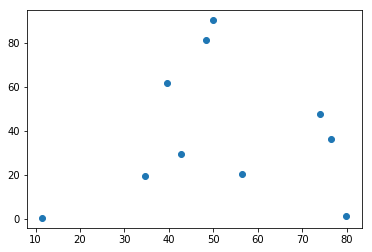

In [14]:
# create the cities and plot the initial order
random.seed(169)
x = np.random.rand(numCities) * 100
y = np.random.rand(numCities) * 100
plt.plot(x,y,ls='',marker='o')
plt.show()

## Optimise!

https://deap.readthedocs.io/en/master/api/algo.html  

The `algorithms` module is intended to contain some specific algorithms in order to execute very common evolutionary algorithms. The method used here are more for convenience than reference as the implementation of every evolutionary algorithm may vary infinitely. Most of the algorithms in this module use operators registered in the toolbox. Generally, the keyword used are `mate()` for crossover, `mutate()` for mutation, `select()` for selection and `evaluate()` for evaluation. This function expects the `toolbox.mate()`, `toolbox.mutate()`, `toolbox.select()` and `toolbox.evaluate()` aliases to be registered in the toolbox.

The algorithm returns the optimized population and a Logbook with the statistics of the evolution. The logbook will contain the generation number, the number of evaluations for each generation and the statistics if a Statistics is given as argument.

Start with a large population of possible routes. 

The code uses one of the built-in algorithms `algorithms.eaSimple`, where you set the main parameters for the run: 

    deap.algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen[, stats, halloffame, verbose])

    population – A list of individuals.
    toolbox – A Toolbox that contains the evolution operators.
    cxpb – The probability of mating two individuals.
    mutpb – The probability of mutating an individual.
    ngen – The number of generation.
    stats – A Statistics object that is updated inplace, optional.
    halloffame – A HallOfFame object that will contain the best individuals, optional.
    verbose – Whether or not to log the statistics.

[Individual('i', [5, 8, 6, 1, 0, 2, 9, 7, 3, 4])]


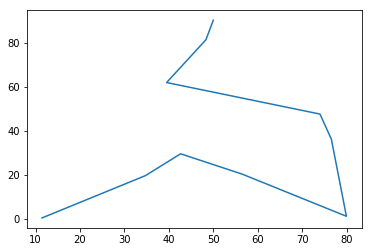

In [15]:
#initial populatiom
pop = toolbox.population(n=POP_SIZE)

# save only the best individual
hof = tools.HallOfFame(1)

# code the GA algorithm
result, log = algorithms.eaSimple(pop,toolbox,cxpb=CX_PROB, mutpb=MUT_PROB, stats=stats,
                                  ngen=MAX_GEN, halloffame=hof,verbose=False)

# plot the best one
print(hof)
plt.plot(x[hof[0]],y[hof[0]]);
 

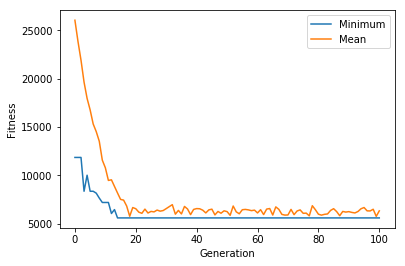

In [16]:
gen = log.select('gen')
fit_mins = log.select('min')
fit_avgs = log.select('avg')

plt.plot(gen,fit_mins,label='Minimum');
plt.plot(gen,fit_avgs,label='Mean');
plt.xlabel("Generation")
plt.ylabel("Fitness");
plt.legend();
